In [1]:

import re
import os
import sys
import pickle
from collections import Counter

import numpy as np
import pandas as pd
import networkx as nx
import pybedtools as bt
from scipy import stats

from scipy.spatial import distance
from scipy.cluster import hierarchy

from scipy.stats import spearmanr
from adjustText import adjust_text



import matplotlib.patches as mpatches
import matplotlib.collections as mcol

import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import gridspec
from matplotlib.lines import Line2D
from mycolorpy import colorlist as mcp

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib_venn import venn2

color1=mcp.gen_color(cmap="Reds",n=10)[-7:-2]
color2=mcp.gen_color(cmap="Greys",n=10)[-5:]
color3=mcp.gen_color(cmap="Oranges",n=10)[-7:-2]
color4=mcp.gen_color(cmap="Greens",n=10)[-7:-2]
sns.set(style="ticks", font_scale=2)

mcp.gen_color(cmap="Purples",n=10)[-7:-2]

def flatten(l):
    return [item for sublist in l for item in sublist]


In [3]:
BEDPRO = pickle.load(open('data/BEDPRO.p', 'rb'))


# N contains BW signal for RNA seq but BEDPRO contains  
N = pd.read_table('data/Epigenome.tmm.tsv').set_index('Name').drop_duplicates()
N.loc[N.index.isin(BEDPRO['Name']), 'RNAseq_Vh'] = N[N.index.isin(BEDPRO['Name'])].index.map(dict(zip(BEDPRO['Name'], BEDPRO['Vh'])))
N.loc[N.index.isin(BEDPRO['Name']), 'RNAseq_30m'] = N[N.index.isin(BEDPRO['Name'])].index.map(dict(zip(BEDPRO['Name'], BEDPRO['30m'])))
N.loc[N.index.isin(BEDPRO['Name']), 'RNAseq_4h'] = N[N.index.isin(BEDPRO['Name'])].index.map(dict(zip(BEDPRO['Name'], BEDPRO['4h'])))
N.loc[N.index.isin(BEDPRO['Name']), 'RNAseq_16h'] = N[N.index.isin(BEDPRO['Name'])].index.map(dict(zip(BEDPRO['Name'], BEDPRO['16h'])))
N.loc[N.index.isin(BEDPRO['Name']), 'RNAseq_72h'] = N[N.index.isin(BEDPRO['Name'])].index.map(dict(zip(BEDPRO['Name'], BEDPRO['72h'])))

MAPty = pickle.load(open('data/MAPty.p', 'rb'))
MAPcl = pickle.load(open('data/MAPcl.p', 'rb'))

H = pickle.load(open('data/G_ALL.p', 'rb'))
#H = pickle.load(open('data/G_ALL.e5.p', 'rb'))

In [4]:
bed = pd.read_table('FOXA1/sets/11_ATAC.ALL_FOXA1.ALL.bed', names=['Chr', 'Start', 'End'])
bed['Name'] = bed['Chr'] +':'+ bed['Start'].astype(str) +'-'+ bed['End'].astype(str)
bed['Set'] = bed['Name'].map(MAPcl)
bed

,Chr,Start,End,Name,Set
0,chr1,751985,756985,chr1:751985-756985,cre
1,chr1,760223,765223,chr1:760223-765223,cre
2,chr1,1086842,1091842,chr1:1086842-1091842,cre
3,chr1,1090409,1095409,chr1:1090409-1095409,cre
4,chr1,1170454,1175454,chr1:1170454-1175454,cre
...,...,...,...,...,...
19196,chrY,23790696,23795696,chrY:23790696-23795696,cre
19197,chrY,23801786,23806786,chrY:23801786-23806786,cre
19198,chrY,23831850,23836850,chrY:23831850-23836850,ARcre
19199,chrY,28540043,28545043,chrY:28540043-28545043,cre


In [5]:

np.random.seed(7)
andr = [n for n, nc in MAPcl.items() if nc == 'ANDR']
high = np.random.choice([n for n, nc in MAPcl.items() if nc == 'High'], size=len(andr))
midh = np.random.choice([n for n, nc in MAPcl.items() if nc == 'Mid-high'], size=len(andr))
len(high), len(midh), len(andr)

(89, 89, 89)

Text(0.5, 0.98, 'Promoter View')

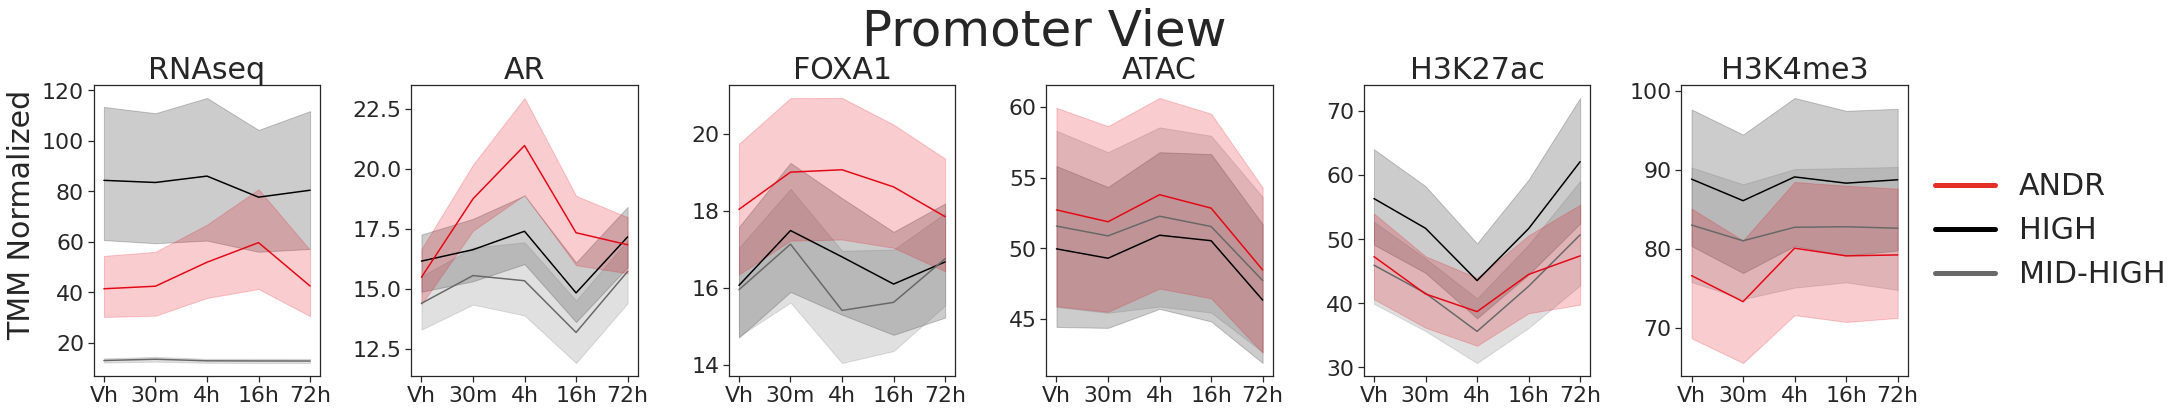

In [4]:

fig = plt.figure(figsize=[30,6])
gs = gridspec.GridSpec(nrows=1, ncols=6, left=0.06, wspace=0.4, top=0.8)


for i, s in enumerate([ 'RNAseq', 'AR', 'FOXA1', 'ATAC', 'H3K27ac', 'H3K4me3']):
    fig.add_subplot(gs[i])
    
    n = N[N.index.isin(high)].drop_duplicates()
    n = n.stack().reset_index()
    tmp = n['level_1'].str.split('_', expand=True)

    n['Signal'] = tmp[0]
    n['Time'] = tmp[1]


    sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color=color2[-1])
    
    n = N[N.index.isin(midh)].drop_duplicates()
    n = n.stack().reset_index()
    tmp = n['level_1'].str.split('_', expand=True)

    n['Signal'] = tmp[0]
    n['Time'] = tmp[1]


    sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color=color2[-4])

    n = N[N.index.isin(andr)].drop_duplicates()
    n = n.stack().reset_index()
    tmp = n['level_1'].str.split('_', expand=True)

    n['Signal'] = tmp[0]
    n['Time'] = tmp[1]

    sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color='#e50714')
    plt.ylabel('')
    plt.xlabel('')
    plt.title(s, fontsize=30)
    
fig.supylabel('TMM Normalized',fontsize=30)




handles = [Line2D([0], [0], color="#e32f27", lw=5), Line2D([0], [0], color=color2[-1], lw=5), Line2D([0], [0], color=color2[-4], lw=5)]
labels = [f"ANDR", f"HIGH", 'MID-HIGH']

plt.legend(handles, labels,loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon=False, fontsize=30)
fig.suptitle('Promoter View', fontsize=50)

#fig.savefig('../plots/PromoterViewEpigenome.pdf', bbox_inches ="tight",  pad_inches = 1 )

Text(0.5, 0.98, 'Promoter View')

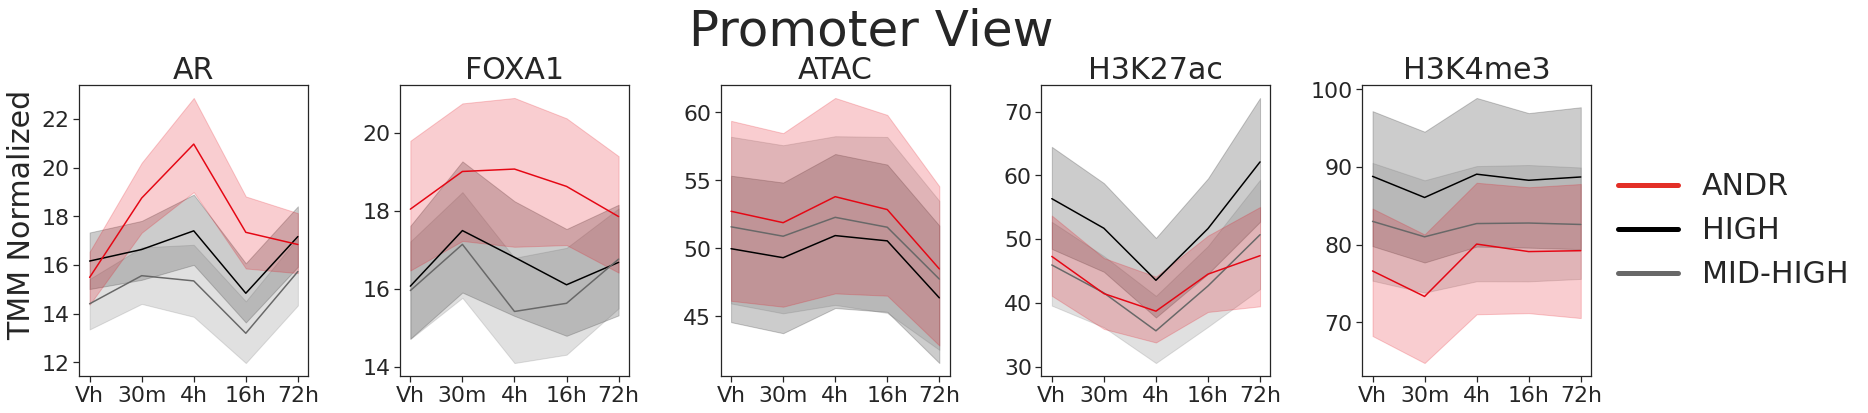

In [5]:

fig = plt.figure(figsize=[25,6])
gs = gridspec.GridSpec(nrows=1, ncols=5, left=0.06,wspace=0.4,top=0.8)

for i, s in enumerate(['AR', 'FOXA1', 'ATAC', 'H3K27ac', 'H3K4me3']):
    fig.add_subplot(gs[i])
    
    n = N[N.index.isin(high)].drop_duplicates()
    n = n.stack().reset_index()
    tmp = n['level_1'].str.split('_', expand=True)

    n['Signal'] = tmp[0]
    n['Time'] = tmp[1]


    sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color=color2[-1])
    
    n = N[N.index.isin(midh)].drop_duplicates()
    n = n.stack().reset_index()
    tmp = n['level_1'].str.split('_', expand=True)

    n['Signal'] = tmp[0]
    n['Time'] = tmp[1]


    sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color=color2[-4])

    n = N[N.index.isin(andr)].drop_duplicates()
    n = n.stack().reset_index()
    tmp = n['level_1'].str.split('_', expand=True)

    n['Signal'] = tmp[0]
    n['Time'] = tmp[1]

    sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color='#e50714')
    plt.ylabel('')
    plt.xlabel('')
    plt.title(s, fontsize=30)
    
fig.supylabel('TMM Normalized',fontsize=30)




handles = [Line2D([0], [0], color="#e32f27", lw=5), Line2D([0], [0], color=color2[-1], lw=5), Line2D([0], [0], color=color2[-4], lw=5)]
labels = [f"ANDR", f"HIGH", 'MID-HIGH']

plt.legend(handles, labels,loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon=False, fontsize=30)
fig.suptitle('Promoter View', fontsize=50)

#fig.savefig('../plots/PromoterViewEpigenome_woRNA.pdf', bbox_inches ="tight",  pad_inches = 1 )

In [6]:
l = list(set(flatten([list(H.neighbors(a)) for a in andr if a in H.nodes])))
arcre_andr_kac = [l_ for l_ in l if MAPcl[l_] == 'ARcre']

l = list(set(flatten([list(H.neighbors(a)) for a in andr  if a in H.nodes])))
cre_andr_kac = [l_ for l_ in l if MAPcl[l_] == 'cre']

l = list(set(flatten([list(H.neighbors(a)) for a in high  if a in H.nodes])))
cre_midh_kac = [l_ for l_ in l if MAPcl[l_] == 'cre']

Text(0.5, 0.98, '                      Enhancer View')

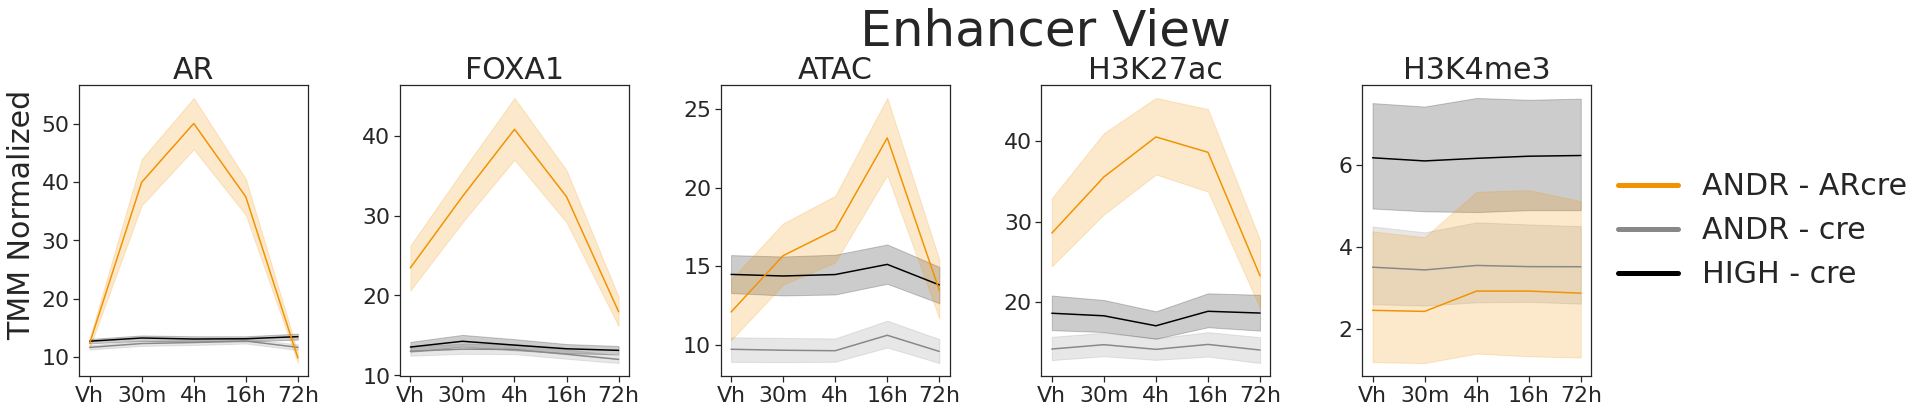

In [7]:

fig = plt.figure(figsize=[25,6])
gs = gridspec.GridSpec(nrows=1, ncols=5, left=0.06,wspace=0.4,top=0.8)


for i, s in enumerate([ 'AR', 'FOXA1', 'ATAC', 'H3K27ac', 'H3K4me3',]):
    fig.add_subplot(gs[i])


    n = N[N.index.isin(cre_andr_kac)].drop_duplicates()
    n = n.stack().reset_index()
    tmp = n['level_1'].str.split('_', expand=True)

    n['Signal'] = tmp[0]
    n['Time'] = tmp[1]

    sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color='#888888')
    plt.title(s, fontsize=30)
    
    
    n = N[N.index.isin(cre_midh_kac)].drop_duplicates()
    n = n.stack().reset_index()
    tmp = n['level_1'].str.split('_', expand=True)

    n['Signal'] = tmp[0]
    n['Time'] = tmp[1]

    sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color='#000000')
    plt.ylabel('')
    plt.xlabel('')
    plt.title(s, fontsize=30)
    
    n = N[N.index.isin(arcre_andr_kac)].drop_duplicates()
    n = n.stack().reset_index()
    tmp = n['level_1'].str.split('_', expand=True)

    n['Signal'] = tmp[0]
    n['Time'] = tmp[1]
    sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color='#f29201')
    
    plt.ylabel('')
    plt.xlabel('')

fig.supylabel('TMM Normalized',fontsize=30)



handles = [Line2D([0], [0], color='#f29201', lw=5),  Line2D([0], [0], color="#888888", lw=5), Line2D([0], [0], color="#000000", lw=5)]
#labels = ["AR regulated\ngene - AR CRE", "AR regulated\ngene - CRE", "Non-AR regulated\ngene - CRE"]
labels = ['ANDR - ARcre', 'ANDR - cre', 'HIGH - cre']
plt.legend(handles, labels,loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon=False, fontsize=30)

fig.suptitle('                      Enhancer View', fontsize=50)

#fig.savefig('../plots/EnhancerViewEpigenome.pdf', bbox_inches ="tight",  pad_inches = 1 )

<AxesSubplot:xlabel='0', ylabel='Density'>

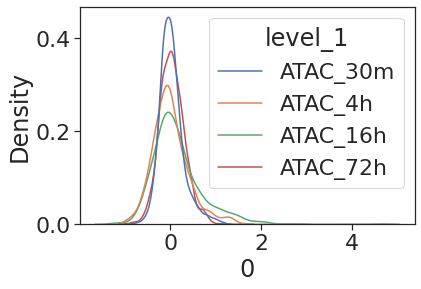

In [38]:
n = N[N.index.isin(cre_andr_kac)].drop_duplicates()
#n = n.stack().reset_index()
#t= n[['ATAC_Vh','ATAC_30m','ATAC_4h','ATAC_16h','ATAC_72h']]


l = np.log2((n.T+1) / (1+n['ATAC_Vh'])).T[['ATAC_30m', 'ATAC_4h', 'ATAC_16h', 'ATAC_72h']].stack().reset_index()


sns.kdeplot(data=l, x=0, hue='level_1')


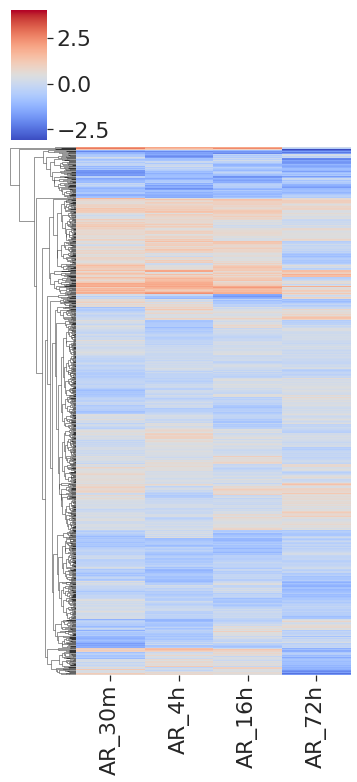

In [51]:
signal = 'AR'
n = N[N.index.isin(cre_andr_kac)].drop_duplicates()

cl = sns.clustermap(np.log2((n.T+1) / (1+n[f'{signal}_Vh'])).T[[f'{signal}_30m', f'{signal}_4h', f'{signal}_16h', f'{signal}_72h']], col_cluster=False, cmap='coolwarm', vmax=4)
cl.ax_heatmap.set_yticks([])
cl.ax_heatmap.set_ylabel('')

cl.ax_heatmap.set_xticks([0.5, 1.5, 2.5, 3.5],  [f'{signal}_30m', f'{signal}_4h', f'{signal}_16h', f'{signal}_72h'], rotation=90)

# Same y-limit

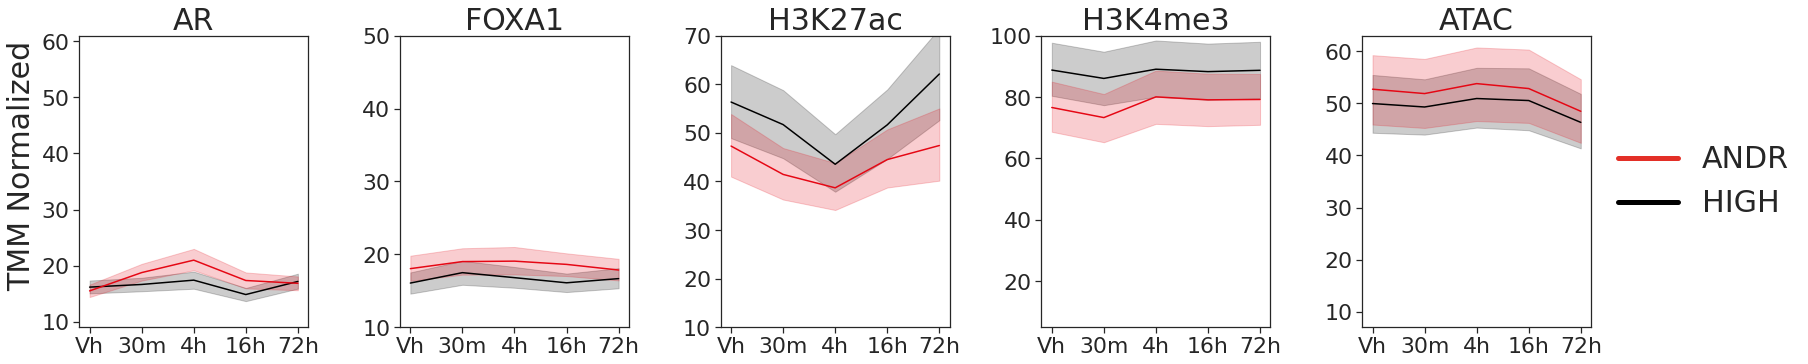

In [4]:

fig = plt.figure(figsize=[25,6])
gs = gridspec.GridSpec(nrows=1, ncols=5, left=0.06,wspace=0.4,top=0.8)

ylims = {'AR': (9,61), 'FOXA1': (10,50), 'H3K27ac': (10,70), 'H3K4me3': (5,100), 'ATAC': (7,63)}

for i, s in enumerate(['AR', 'FOXA1', 'H3K27ac', 'H3K4me3', 'ATAC']):
    fig.add_subplot(gs[i])
    
    n = N[N.index.isin(high)].drop_duplicates()
    n = n.stack().reset_index()
    tmp = n['level_1'].str.split('_', expand=True)

    n['Signal'] = tmp[0]
    n['Time'] = tmp[1]


    sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color=color2[-1])


    n = N[N.index.isin(andr)].drop_duplicates()
    n = n.stack().reset_index()
    tmp = n['level_1'].str.split('_', expand=True)

    n['Signal'] = tmp[0]
    n['Time'] = tmp[1]

    sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color='#e50714')
    plt.ylabel('')
    plt.xlabel('')
    plt.title(s, fontsize=30)

    plt.ylim(ylims[s])
    
fig.supylabel('TMM Normalized',fontsize=30)


handles = [Line2D([0], [0], color="#e32f27", lw=5), Line2D([0], [0], color=color2[-1], lw=5)]
labels = [f"ANDR", f"HIGH"]

plt.legend(handles, labels,loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon=False, fontsize=30)
#fig.suptitle('Promoter View', fontsize=50)

#fig.savefig('../plots/ylim_PromoterViewEpigenome.pdf', bbox_inches ="tight",  pad_inches = 1 )

In [37]:
foxar = bed.loc[bed['Set'] == 'ARcre', 'Name'].tolist()
foxcre = bed.loc[bed['Set'] == 'cre', 'Name'].tolist()



l = list(set(flatten([list(H.neighbors(a)) for a in andr if a in H.nodes])))
arcre_andr_kac_fox = [l_ for l_ in l if (MAPcl[l_] == 'ARcre') & (l_ in foxar) ]
print( len(arcre_andr_kac_fox))

cre_andr_kac_fox = [l_ for l_ in l if (MAPcl[l_] == 'cre') & (l_ in foxcre) ]
print( len(cre_andr_kac_fox))

l = list(set(flatten([list(H.neighbors(a)) for a in andr  if a in H.nodes])))
cre_andr_kac = [l_ for l_ in l if MAPcl[l_] == 'cre']

l = list(set(flatten([list(H.neighbors(a)) for a in high  if a in H.nodes])))
cre_high_kac = [l_ for l_ in l if MAPcl[l_] == 'cre']

l = list(set(flatten([list(H.neighbors(a)) for a in high  if a in H.nodes])))
arcre_high_kac = [l_ for l_ in l if MAPcl[l_] == 'ARcre']

157
259


In [12]:
l

['chr9:139662026-139667026',
 'chr15:93195698-93200698',
 'chr3:156774171-156779171',
 'chr11:126207835-126212835',
 'chr15:44082537-44087537',
 'chr17:74347779-74352779',
 'chr14:24581723-24586723',
 'chr15:89635077-89640077',
 'chr10:134753827-134758827',
 'chr1:43635515-43640515',
 'chr19:15664706-15669706',
 'chr14:24699160-24704160',
 'chr12:131321311-131326311',
 'chr17:45320669-45325669',
 'chr10:43902114-43907114',
 'chr9:112061093-112066093',
 'chr17:57295334-57300334',
 'chr16:68810805-68815805',
 'chr17:45498575-45503575',
 'chr12:49210014-49215014',
 'chr7:156942090-156947090',
 'chr5:79445129-79450129',
 'chr3:67668381-67673381',
 'chr19:24095184-24100184',
 'chr16:30966115-30971115',
 'chr5:137908633-137913633',
 'chr11:57059832-57064832',
 'chr2:232643519-232648519',
 'chr13:99372103-99377103',
 'chr17:76783369-76788369',
 'chr19:15945458-15950458',
 'chr11:125874907-125879907',
 'chr17:57456718-57461718',
 'chr8:145548073-145553073',
 'chr8:11657620-11662620',
 'chr1:43

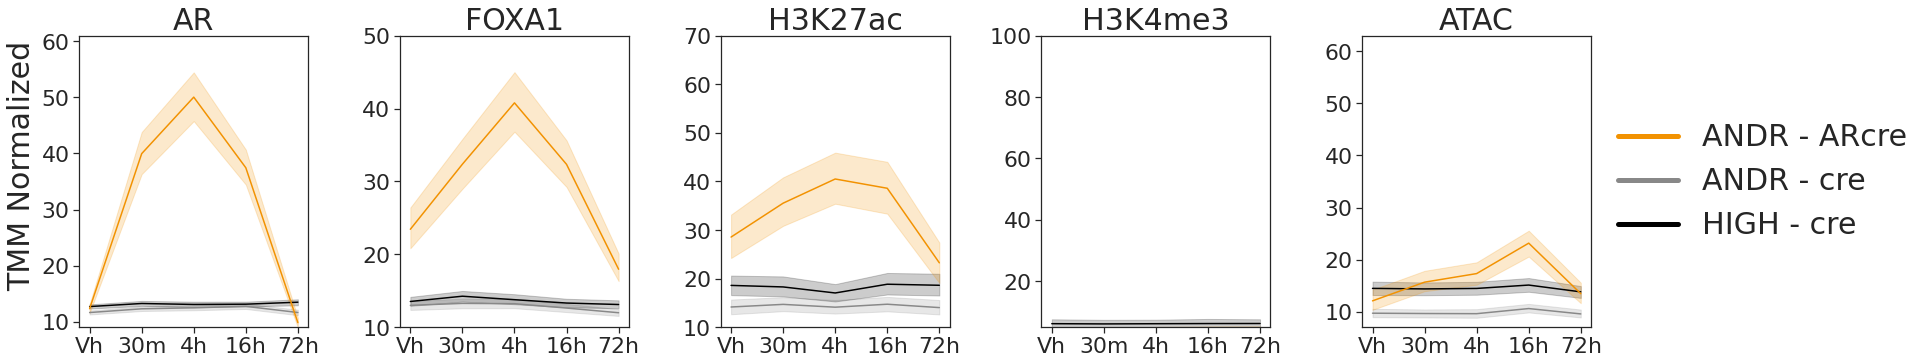

In [10]:

fig = plt.figure(figsize=[25,6])
gs = gridspec.GridSpec(nrows=1, ncols=5, left=0.06,wspace=0.4,top=0.8)


for i, s in enumerate([ 'AR', 'FOXA1', 'H3K27ac', 'H3K4me3','ATAC']):
    fig.add_subplot(gs[i])


    n = N[N.index.isin(cre_andr_kac)].drop_duplicates()
    n = n.stack().reset_index()
    tmp = n['level_1'].str.split('_', expand=True)

    n['Signal'] = tmp[0]
    n['Time'] = tmp[1]

    sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color='#888888')
    plt.title(s, fontsize=30)
    
    
    n = N[N.index.isin(cre_midh_kac)].drop_duplicates()
    n = n.stack().reset_index()
    tmp = n['level_1'].str.split('_', expand=True)

    n['Signal'] = tmp[0]
    n['Time'] = tmp[1]

    sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color='#000000')
    plt.ylabel('')
    plt.xlabel('')
    plt.title(s, fontsize=30)
    
    n = N[N.index.isin(arcre_andr_kac)].drop_duplicates()
    n = n.stack().reset_index()
    tmp = n['level_1'].str.split('_', expand=True)

    n['Signal'] = tmp[0]
    n['Time'] = tmp[1]
    sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color='#f29201')
    
    plt.ylabel('')
    plt.xlabel('')

    plt.ylim(ylims[s])

fig.supylabel('TMM Normalized',fontsize=30)



handles = [Line2D([0], [0], color='#f29201', lw=5),  Line2D([0], [0], color="#888888", lw=5), Line2D([0], [0], color="#000000", lw=5)]
#labels = ["AR regulated\ngene - AR CRE", "AR regulated\ngene - CRE", "Non-AR regulated\ngene - CRE"]
labels = ['ANDR - ARcre', 'ANDR - cre', 'HIGH - cre']
plt.legend(handles, labels,loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon=False, fontsize=30)


fig.savefig('../plots/ylim_EnhancerViewEpigenome.pdf', bbox_inches ="tight",  pad_inches = 1 )

# AR VS NON-AR FOCUS

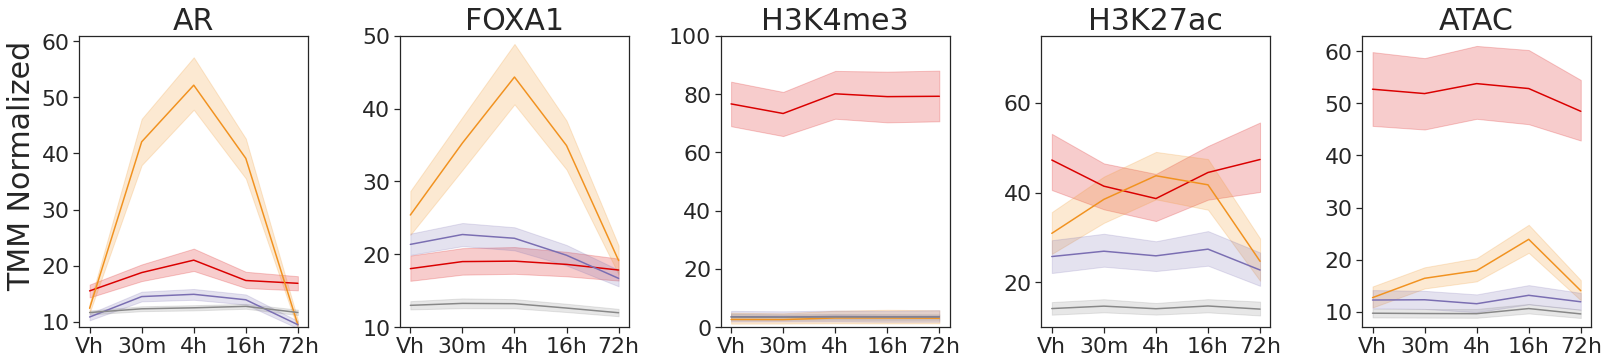

In [35]:

fig = plt.figure(figsize=[25,6])
gs = gridspec.GridSpec(nrows=1, ncols=5, left=0.06,wspace=0.4,top=0.8)

ylims = {'AR': (9,61), 'FOXA1': (10,50), 'H3K27ac': (10,75), 'H3K4me3': (0,100), 'ATAC': (7,63)}

for i, s in enumerate(['AR', 'FOXA1', 'H3K4me3', 'H3K27ac', 'ATAC']):
    fig.add_subplot(gs[i])
    
    n = N[N.index.isin(andr)].drop_duplicates()
    n = n.stack().reset_index()
    tmp = n['level_1'].str.split('_', expand=True)

    n['Signal'] = tmp[0]
    n['Time'] = tmp[1]


    sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color='#DA0000')


    n = N[N.index.isin(arcre_andr_kac_fox)].drop_duplicates()
    n = n.stack().reset_index()
    tmp = n['level_1'].str.split('_', expand=True)

    n['Signal'] = tmp[0]
    n['Time'] = tmp[1]

    sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color='#F19220')
    plt.ylabel('')
    plt.xlabel('')
    plt.title(s, fontsize=30)

    plt.ylim(ylims[s])

    n = N[N.index.isin(cre_andr_kac_fox)].drop_duplicates()
    n = n.stack().reset_index()
    tmp = n['level_1'].str.split('_', expand=True)

    n['Signal'] = tmp[0]
    n['Time'] = tmp[1]

    sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color='#7A6EB2')
    plt.ylabel('')
    plt.xlabel('')
    plt.title(s, fontsize=30)

    plt.ylim(ylims[s])


    n = N[N.index.isin(cre_andr_kac)].drop_duplicates()
    n = n.stack().reset_index()
    tmp = n['level_1'].str.split('_', expand=True)

    n['Signal'] = tmp[0]
    n['Time'] = tmp[1]

    sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color='#888888')
    plt.ylabel('')
    plt.xlabel('')
    plt.title(s, fontsize=30)

    plt.ylim(ylims[s])
    
    
fig.supylabel('TMM Normalized',fontsize=30)


handles = [Line2D([0], [0], color="#e32f27", lw=5), Line2D([0], [0], color=color2[-1], lw=5)]
labels = [f"ANDR", f"HIGH"]

#plt.legend(handles, labels,loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon=False, fontsize=30)
#fig.suptitle('Promoter View', fontsize=50)

fig.savefig('../plots/AR_epigenome_FINAL.pdf', bbox_inches ="tight",  pad_inches = 1 )

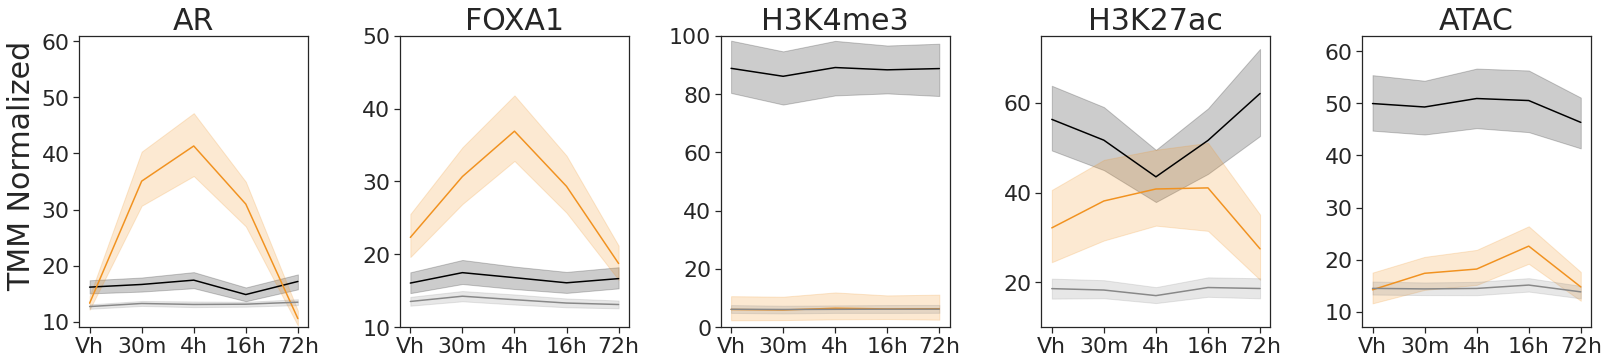

In [38]:

fig = plt.figure(figsize=[25,6])
gs = gridspec.GridSpec(nrows=1, ncols=5, left=0.06,wspace=0.4,top=0.8)

ylims = {'AR': (9,61), 'FOXA1': (10,50), 'H3K27ac': (10,75), 'H3K4me3': (0,100), 'ATAC': (7,63)}

for i, s in enumerate(['AR', 'FOXA1', 'H3K4me3', 'H3K27ac', 'ATAC']):
    fig.add_subplot(gs[i])
    
    n = N[N.index.isin(high)].drop_duplicates()
    n = n.stack().reset_index()
    tmp = n['level_1'].str.split('_', expand=True)

    n['Signal'] = tmp[0]
    n['Time'] = tmp[1]


    sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color='#000000')

    n = N[N.index.isin(arcre_high_kac)].drop_duplicates()
    n = n.stack().reset_index()
    tmp = n['level_1'].str.split('_', expand=True)

    n['Signal'] = tmp[0]
    n['Time'] = tmp[1]

    sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color='#F19220')
    plt.ylabel('')
    plt.xlabel('')
    plt.title(s, fontsize=30)

    plt.ylim(ylims[s])



    n = N[N.index.isin(cre_high_kac)].drop_duplicates()
    n = n.stack().reset_index()
    tmp = n['level_1'].str.split('_', expand=True)

    n['Signal'] = tmp[0]
    n['Time'] = tmp[1]

    sns.lineplot(data=n[n['Signal'] == s],x='Time', y=0, color='#888888')
    plt.ylabel('')
    plt.xlabel('')
    plt.title(s, fontsize=30)

    plt.ylim(ylims[s])
    
    
fig.supylabel('TMM Normalized',fontsize=30)


handles = [Line2D([0], [0], color="#e32f27", lw=5), Line2D([0], [0], color=color2[-1], lw=5)]
labels = [f"ANDR", f"HIGH"]

#plt.legend(handles, labels,loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon=False, fontsize=30)
#fig.suptitle('Promoter View', fontsize=50)

fig.savefig('../plots/nAR_epigenome_FINAL.pdf', bbox_inches ="tight",  pad_inches = 1 )

In [10]:
len(arcre_andr_kac), len(cre_andr_kac), len(cre_midh_kac)

(178, 932, 818)

In [11]:
n

,Name,level_1,0,Signal,Time
0,chr1:55345858-55350858,ATAC_Vh,4.713587,ATAC,Vh
1,chr1:55345858-55350858,ATAC_30m,8.317839,ATAC,30m
2,chr1:55345858-55350858,ATAC_4h,14.593974,ATAC,4h
3,chr1:55345858-55350858,ATAC_16h,21.126181,ATAC,16h
4,chr1:55345858-55350858,ATAC_72h,5.592026,ATAC,72h
...,...,...,...,...,...
5335,chrX:23904381-23909381,FOXA1_Vh,18.872978,FOXA1,Vh
5336,chrX:23904381-23909381,FOXA1_30m,25.121592,FOXA1,30m
5337,chrX:23904381-23909381,FOXA1_4h,39.114297,FOXA1,4h
5338,chrX:23904381-23909381,FOXA1_16h,27.540371,FOXA1,16h
